## Second attempt at a U-NET

So a UNET has three phases: contraction, bottleneck and expansion.

**Contraction**  
- Consists of repeated application of two 3x3 convolutions (unpadded), each followed by RELU-activation and then a (2x2) max pooling with stride 2.
- At each downsampling we double the number of feature channels.

**Bottleneck**

**Expansion**
- Consists of an upsampling of feature map followed by a 2x2 convolution, a concatenation with the corresponding cropped feature map from the conraction part and two 3x3 convolutions each followed by RELU-activation.
- Halves the number of feature samples.

**Final Layer**
- 1x1 convolution to obtain desired number of classes. For us only 2 (road, not road)

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image


In [2]:
from src.helpers import load_image

In [3]:
from skimage.transform import resize

def shape_training_data(imgs, gt_imgs):
    SIZE = (256, 256)
    n = len(imgs)
    
    imgs = [resize(img, SIZE) for img in imgs]
    gt_imgs = [resize(gt_img, SIZE) for gt_img in gt_imgs]
    
    gt_imgs = [gt_imgs[i].reshape(256, 256, 1) for i in range(n)]
    gt_imgs = [np.around(gt_imgs[i]) for i in range(n)]
    
    return np.asarray(imgs), np.asarray(gt_imgs)

def load_training_data(datapath, num_samples):
    
    image_dir = datapath + "images/"
    files = os.listdir(image_dir)
    n = min(num_samples, len(files)) # Load maximum 20 images
    
    print("Loading " + str(n) + " images")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = datapath + "groundtruth/"
    print("Loading " + str(n) + " images")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    return shape_training_data(imgs, gt_imgs)


    

In [31]:
x, y = load_training_data('data/training/', 20)

x_tr = x[0:10, :, : , :]
x_te = x[10:15, :, : , :]

y_tr = y[0:10, :, : , :]
y_te = y[10:15, :, : , :]
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape


Loading 20 images
Loading 20 images


((10, 256, 256, 3), (10, 256, 256, 1), (5, 256, 256, 3), (5, 256, 256, 1))

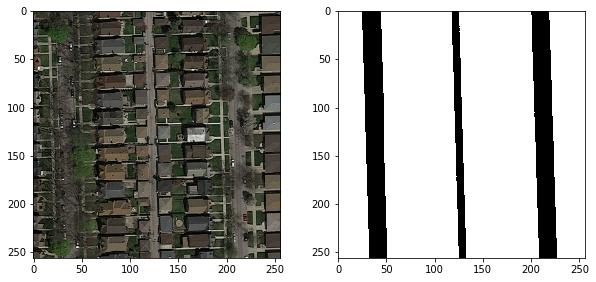

In [5]:
plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.imshow(x_tr[0])

plt.subplot(2,2,2)
plt.imshow(y_tr[0].reshape(256, 256), cmap="Greys")

In [154]:


def contraction_block(x, filters, kernel_size = (3), padding = 'same', strides = 1):
    
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(x)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    p = MaxPool2D((2,2), (2,2))(c)
    return c, p

def expansion_block(x, skip, filters, kernel_size = (3), padding = 'same', strides = 1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(concat)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    
    return c

def bottleneck(x, filters, kernel_size = (3), padding = 'same', strides = 1):
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(x)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    return c
    

In [155]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input, Dropout
from keras.models import Model

def UNET():
    IMAGE_SIZE = (256, 256, 3)
    
    inputs = Input((IMAGE_SIZE))
    p0 = inputs
    
    # Contraction Block
    c1 = Conv2D(64, 3, padding='same', activation='relu')(p0)
    c1 = Conv2D(64, 3, padding='same', activation='relu')(c1)
    p1 = MaxPool2D(pool_size = (2,2))(c1)
    
    c2 = Conv2D(128, 3, padding='same', activation='relu')(p1)
    c2 = Conv2D(128, 3, padding='same', activation='relu')(c2)
    drop2 = Dropout(0.5)(c2)
    p2 = MaxPool2D(pool_size = (2,2))(drop2)
    
    #Bottleneck
    bn = Conv2D(256, 3, padding='same', activation='relu')(p2)
    bn = Conv2D(256, 3, padding='same', activation='relu')(bn)
    drop_bn = Dropout(0.5)(bn)
    
    # Expansion Block
    up1 = UpSampling2D(size = (2,2))(drop_bn)
    concat1 = Concatenate()([drop2, up1])
    c3 = Conv2D(128, 3, padding='same', activation='relu')(concat1)
    c3 = Conv2D(128, 3, padding='same', activation='relu')(c3)
    
    up2 = UpSampling2D(size = (2,2))(c3)
    concat2 = Concatenate()([c1, up2])
    c3 = Conv2D(64, 3, padding='same', activation='relu')(concat2)
    c3 = Conv2D(64, 3, padding='same', activation='relu')(c3)
    c4 = Conv2D(2, 3, padding='same', activation='relu')(c3)
    
    output = Conv2D(1, 1, padding="same", activation='sigmoid')(c4)
    model = Model(inputs, output)
    
    return model


In [156]:
model = UNET()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ["acc"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.fit(x=x_tr, y = y_tr,  validation_data =(x_te, y_te), epochs=2)

Train on 3 samples, validate on 2 samples
Epoch 1/2


In [ ]:
model.save_weights("UNET_FIRSTTRY.h5")

In [191]:
model.load_weights("UNET_FIRSTTRY.h5")

In [192]:
val = x[0:5, :, :, :]
result = model.predict(val)

In [228]:
test = result[2].reshape(256,256)


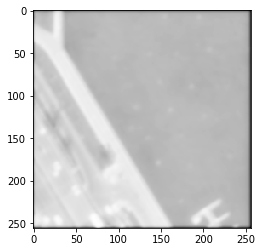

In [229]:
plt.imshow(test, cmap = "Greys")

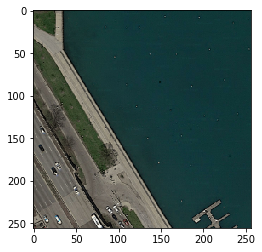

In [218]:
gt_val = x[0:5, :, : , :]
plt.imshow(gt_val[2].reshape(256, 256, 3), cmap = "Greys")
